/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: 

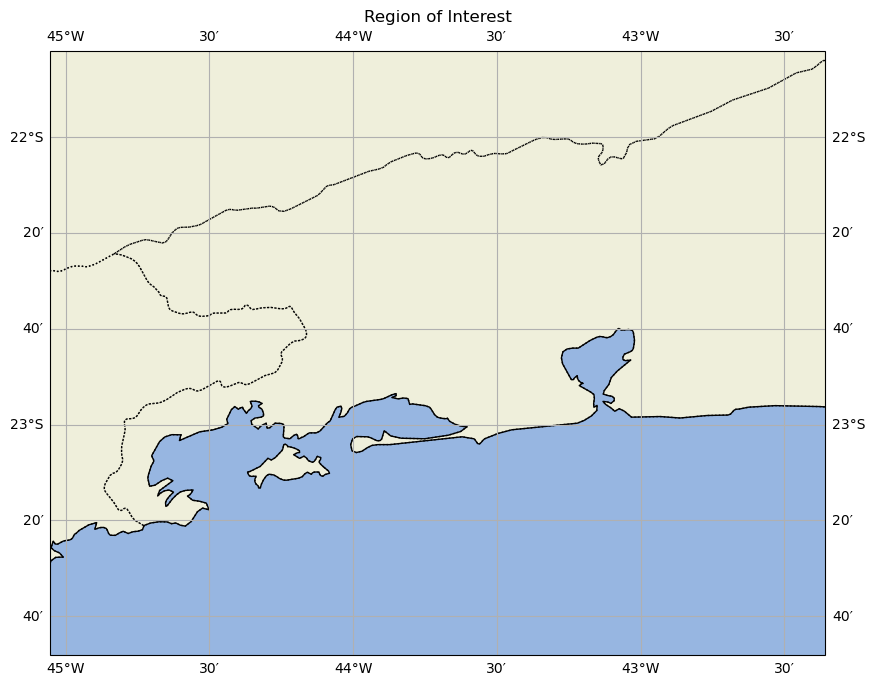

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Coordinates for the region of interest
lat_max, lon_max = -21.699774257353113, -42.35676996062447  # Upper-right corner
lat_min, lon_min = -23.801876626302175, -45.05290312102409  # Lower-left corner

# Create a figure with Cartopy projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map to the region of interest
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add geographic features (optional)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add gridlines for better readability
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot title
plt.title('Region of Interest')

# Show the plot
plt.show()


In [4]:
import numpy as np

import datetime as dt
import logging

import xarray as xr

def LonLat2ABIangle(lon_deg, lat_deg, z, H, req, rpol, e, lon_0_deg):
    """
    Computes the GOES-R ABI Fixed Grid image coordinates given latitude and longitude (degrees) of a ground point.

    Parameters
    ------------
    lon_deg : float
        longitude of ground point [degrees]
    lat_deg : float
        latitude of ground point [degrees]
    z : float
        elevation of ground point above GRS80 ellipsoid [meters]
    H : float
        satellite distance to Earth center [km]
    req : float
        Earth semi-major axis of GRS80 ellipsoid (equatorial radius) [km]
    rpol : float
        Earth semi-minor axis of GRS80 ellipsoid (polar radius) [km]
    e : float
        eccentricity of ellipsoid (e=0.0818191910435 for GRS80) [unitless]
    lon_0_deg : float
        longitude of projection origin (longitude of sub-satellite point) [degrees]

    Returns
    ------------
    x : float
        ABI Fixed Grid x coordinate (scan angle) [radians]
    y : float
        ABI Fixed Grid y coordinate (elevation angle) [radians]

    Examples
    ------------

    """

    # convert lat and lon from degrees to radians
    lon = np.radians(lon_deg)
    lat = np.radians(lat_deg)
    lon_0 = np.radians(lon_0_deg)

    # geocentric latitude
    lat_geo = np.arctan((rpol**2 / req**2) * np.tan(lat))

    # geocentric distance to point on the ellipsoid
    rc = rpol / np.sqrt(
        1 - (e**2) * (np.cos(lat_geo) ** 2)
    )  # this is rc if point is on the ellipsoid
    if ~isinstance(z, int):
        rc = (
            rc + z
        )  # this is rc if the point is offset from the ellipsoid by z (meters)

    # intermediate calculations
    Sx = H - rc * np.cos(lat_geo) * np.cos(lon - lon_0)
    Sy = -rc * np.cos(lat_geo) * np.sin(lon - lon_0)
    Sz = rc * np.sin(lat_geo)

    # calculate x and y scan angles
    y = np.arctan(Sz / Sx)
    x = np.arcsin(-Sy / np.sqrt(Sx**2 + Sy**2 + Sz**2))

    ## determine if this point is visible to the satellite
    # condition = ( H * (H-Sx) ) < ( Sy**2 + (req**2 / rpol**2)*Sz**2 )
    # if condition == True:
    #    print('Point at {},{} not visible to satellite.'.format(lon_deg,lat_deg))
    #    return (np.nan, np.nan)
    # else:
    #    return (x,y)
    return (x, y)


def subsetNetCDF(filepath, bounds, newfilepath=None):
    """
    Crop a GOES-R ABI NetCDF file to latitude/longitude bounds, add datetime dims/coords.

    Parameters
    ------------
    filepath : str
        path to a NetCDF file
    bounds : list
        list or array containing latitude/longitude bounds like [min_lon, min_lat, max_lon, max_lat]
    newfilepath : str
        path and filename for a new NetCDF file to write out to, defaults to None where it will overwrite the input NetCDF file

    Returns
    ------------
    None

    Examples
    ------------
    Subset a GOES ABI CONUS image so that we only have the western half of CONUS within latitudes 30 and 50, and longitudes -125 and -105.

    >>> bounds = [-125, 30, -105, 50]
    >>> subsetNetCDF('CONUS.nc',bounds,newfilepath='westernCONUS.nc')

    """

    # get bounds: [min_lon, min_lat, max_lon, max_lat]
    lon_west = bounds[0]
    lat_south = bounds[1]
    lon_east = bounds[2]
    lat_north = bounds[3]

    with xr.open_dataset(filepath) as file:
        f = file.load()
        # Values needed for geometry calculations
        req = f.goes_imager_projection.semi_major_axis
        rpol = f.goes_imager_projection.semi_minor_axis
        H = (
            f.goes_imager_projection.perspective_point_height
            + f.goes_imager_projection.semi_major_axis
        )
        lon_0 = f.goes_imager_projection.longitude_of_projection_origin
        e = 0.0818191910435  # GRS-80 eccentricity

        # find corresponding look angles for the four corners
        x_rad_sw, y_rad_sw = LonLat2ABIangle(
            lon_west, lat_south, 0, H, req, rpol, e, lon_0
        )
        logging.info("SW Corner: {}, {}".format(x_rad_sw, y_rad_sw))
        x_rad_se, y_rad_se = LonLat2ABIangle(
            lon_east, lat_south, 0, H, req, rpol, e, lon_0
        )
        logging.info("SE Corner: {}, {}".format(x_rad_se, y_rad_se))
        x_rad_nw, y_rad_nw = LonLat2ABIangle(
            lon_west, lat_north, 0, H, req, rpol, e, lon_0
        )
        logging.info("NW Corner: {}, {}".format(x_rad_nw, y_rad_nw))
        x_rad_ne, y_rad_ne = LonLat2ABIangle(
            lon_east, lat_north, 0, H, req, rpol, e, lon_0
        )
        logging.info("NE Corner: {}, {}".format(x_rad_ne, y_rad_ne))
        # choose the bounds that cover the largest extent
        y_rad_s = min(
            y_rad_sw, y_rad_se
        )  # choose southern-most coordinate (scan angle in radians)
        y_rad_n = max(y_rad_nw, y_rad_ne)  # northern-most
        x_rad_e = max(x_rad_se, x_rad_ne)  # eastern-most (scan angle in radians)
        x_rad_w = min(x_rad_sw, x_rad_nw)  # western-most
        logging.info(
            "Corner coords chosen: N: {}, S: {}; E: {}, W: {}".format(
                y_rad_n, y_rad_s, x_rad_e, x_rad_w
            )
        )
        # Use these coordinates to subset the whole dataset
        y_rad_bnds, x_rad_bnds = [y_rad_n, y_rad_s], [x_rad_w, x_rad_e]
        ds = f.sel(x=slice(*x_rad_bnds), y=slice(*y_rad_bnds))

        # while we have the file open, add datetime dims/coords to the file
        # parse the start time from the file name (the part "s2022__________")
        print(filepath)
        this_datetime = dt.datetime.strptime(
            filepath.stem.split("_")[3][1:-1], "%Y%j%H%M%S"
        )
        ds = ds.assign_coords({"time": this_datetime})
        ds = ds.expand_dims("time")
        ds = ds.reset_coords(drop=True)

    # Close the original file
    f.close()
    if newfilepath is None:
        # Overwrite the original file
        ds.to_netcdf(
            filepath, "w", encoding={"x": {"dtype": "float"}, "y": {"dtype": "float"}}
        )
    else:
        # save to new file
        ds.to_netcdf(
            newfilepath,
            "w",
            encoding={"x": {"dtype": "float"}, "y": {"dtype": "float"}},
        )

    return None

In [5]:
bounds = [-125, 30, -105, 50]
subsetNetCDF('../../goes16_data/OR_ABI-L1b-RadF-M6C10_G16_s20233220000205_e20233220009525_c20233220009561.nc', bounds, newfilepath='temp.nc')

../../goes16_data/OR_ABI-L1b-RadF-M6C10_G16_s20233220000205_e20233220009525_c20233220009561.nc


AttributeError: 'str' object has no attribute 'stem'